<h1>Tutorial </h1>
<h2>Computing Tunneling Rates Ising i-PI</h2>
<h3>Yair Litman</h3>
 <h4>This tutorial is based on a previous tutorial, with contributions from J. Richardson, W. Fang, Y. Litman, V. Kapil, E. Sarolta Pos.</h4>

In this exercise we will use i-PI to compute tunneling rates using the Ring Polymer Instanton  (RPI) rate theory [1]. 
The workflow of this excersice is quite different from the rest of the  tutorials since here we are not going to run any flavour of molecular dynamics but instead we will find stationary points on the ring-polymer potential-energy surface, $V^\text{RP}$.


The instanton geometry or instanton pathway is a stationary points of  $V^\text{RP}$ that connects the reactants and the products. More specifically, it represents a first-order saddle point. In Figure 1, we show two schematic representations of  instanton pathways in 1D and 2D.


<figure>
   <img src="Figures/Instanton_1D_and_2D.png" alt="Alt Text"  width="600">
    
    Figure 1: a) Instanton pathway obtained in a one dimensional barrier b) Instanton pathway obatined in two dimensional potential energy surface. Red and blue represent higher and lower temperatures, respectively. The black dashed lines and the white circle corresponds to the minimum energy pathway and transtion state of the potential energy surface, respectively. Figures adapted from Ref. [2]
  
</figure>
      
    

We will analyze the gas-phase bimolecular scattering reaction of H + CH$_4$, using the CBE potential-energy surface [3]. 
Full technical details of the instanton approach are described in Ref. [2,4].

The simulation requires multiple runs of i-PI for the different stationary points on the surface followed by one postprocessing calculation to combine all the data to compute the rate.

A typical workflow is summarized as follows:


**Part I**: Find Reactant and Product 
* Find the minima on the potential energy surface of the physical system to identify the reactant and the product, Compute the reactant hessian to estimate the vibrational frequencies.

**Part II**: Find Transition State
* Find the first-order saddle point to locate the relevant transition state, and compute its hessian to estimate the vibrational frequencies.


**Part III**: Find the Instanton Pathway with P replicas.


1. Generate an initial guess of the instanton geometry with a reduced amount of replicas, $P$.


2. Run an optimization algorithm to find the first-order saddle point of  $V^\text{RP}$.



3. Is the instanton calculation converged with respect to the number of replicas? yes: go to 6., otherwise continue


4. Use an interpolation scheme to calculate the a ring polymer instanton for a larger number of replicas. Go to 2.


5. Recompute the Hessian for each replica accurately 



6. Estimate the tunneling rate. 



A graphical workflow of this procedure is presented in Fig. 2.


<figure>
   <img src="Figures/workflow.png" alt="Alt Text"  width="300">
  <figcaption>
      Figure 2: Schematic representation of the workflow for an instanton calculation. The rounded
boxes refers to actions or calculations, while the red diamonds to logical decisions. Yellow boxes
are performed automatically by the code, and orange boxes require the use of an external script
provided with the code. P and T refer to the number of replicas and temperature, respectively.
    Figure adapted from Ref. [2].
    </figcaption>
</figure>




If rates are required at more than one temperature, it is recommended to start with the highest one and cool sequentially, again using initial guesses from the previous optimizations. In Fig. 3, we graphical representation of the optimal pathway across the $P,T$ space.

<figure>
  <img src="Figures/Cooling.png" alt="Alt Text"  width="500">
  <figcaption>Figure 3: Graphical representation of the optimatimal optimization pathway during an instanton rate calculation. The gray area illustrates a trade-off between the number of beads needed for a stable optimization and minimal computational cost. Once the optimization reaches the target temperature (represented by the white circle), further optimization with additional beads may be necessary to achieve the desired accuracy for the final reaction rate."    Figure adapted from Ref. [2].
    </figcaption>
</figure>

Let's get started!

In [19]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cycler
from scipy import constants

plt.rc('text', usetex=True)
plt.rc('ps', usedistiller = 'xpdf')
plt.rcParams['legend.fontsize'] = 'x-large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'
params = {'figure.figsize':(12, 5)}
plt.rcParams['axes.prop_cycle'] = cycler(color=['r','b','k','g','y','c'])

#UNITS:  
invcm2au = 4.5563353e-06 #in i-PI unit_to_internal("frequency", "inversecm", 1.0)

def get_freq_from_eigvals(eigvals):
    """Transforms eigenvalues in atomic units to frequencies in cm^-1"""
    freq_invcm = np.zeros(eigvals.shape)
    for i, eig in enumerate(eigvals):
      freq_invcm[i]= np.sign(eig) * np.absolute(eig) ** 0.5 / invcm2au
    return freq_invcm


<h2>Part I - Optimizing and analysing the reactant</h2>

1. Go to the folder `input/reactant/minimization`. A good initial guess has been provided in `init.xyz` and the input file `input.xml`. Look at the input file which should be fairly self explanatory. Note that the text between `<!--` and `-->` is a comment.
Then run i-PI using

    `$ i-pi input.xml &`

    and the driver using
    
    `$ i-pi-driver -m ch4hcbe -u`

	The simulation takes ~ 31 steps and you should get the following message
    
    *Soft exit has been requested with message: 'Geometry optimization converged. Exiting simulation*
    
    
    The final geometry can be seen in the last frame in `min.xc.xyz`. Once you finish this exercise, you could come back here and try to get the optimization to finish in fewer steps, e.g. by changing `sd` to one of the other optimizers.

    Note that as this is a bimolecular reaction, the H and the CH$_4$ should be well separated and we have used a very large box size. 


2. Next, go to the folder `input/reactant/phonons` and copy the optimized geometry just obtained (last 8 lines) into a new file called `init.xyz`.

We will now compute the hessian of this geometry by running:

`$ i-pi input.xml &`

`$ i-pi-driver -m ch4hcbe -u`
    
    The hessian is saved in `phonons.hess` and its eigenvalues in `phonons.eigval`. 
  
   

Let's plot the vibrational frequencies: 

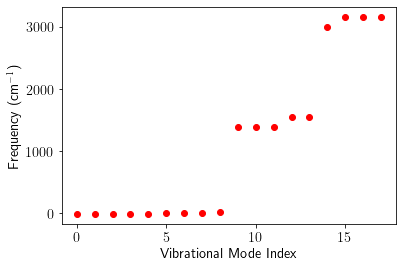

In [30]:
eigvals = np.genfromtxt('input/reactant/phonons/min.phonons.eigval')
fr= get_freq_from_eigvals(eigvals)


plt.plot(fr,'o')
plt.xlabel('Vibrational Mode  Index')
plt.ylabel('Frequency (cm$^{-1}$)')
plt.show()

Check that it has the required number (9) of almost zero frequencies. Why?

<h2>Part II - Optimizing and analysing the transition state</h2>

Go to `input/TS` and optimize the transition state using the usual run commands. Here i-PI treats the TS search as a <strong> one-bead instanton optimization</strong>. The simulation takes ~15 steps and writes the optimized geometry in `ts.instanton_FINAL_12.xyz` and its Hessian in `ts.instanton_FINAL.hess_12`.


If you can, try to visualize the geometry using `vmd`. 
You should find something similar to Figure 4.

<figure>
  <img src="Figures/TS.png" alt="Alt Text"  width="500">
  <figcaption>Figure 4: Transition state strucuture of the bimolecular scattering reaction of H + CH$_4$.
    </figcaption>
</figure>

<h2>Part IIIA - First Instanton Optimization </h2>

Instanton trajectories only exist below a critical temperature known as cross over temperature, $T_c$, which, in most cases, can be estimated by a parabolic barrier approximation as,

<div align="center">
$ T_c= \frac{\hbar \omega^\dagger}{2\pi}k_B$
</div>

where $\omega^\dagger$ is the imaginary frequency at the TS geometry, and $k_B$ the Boltzmann constant.
For this reaction (and this potential energy surface), we obtain $\omega^\dagger$=1488 cm $^{-1}$ which which is a equivalent to 340 K.



 Go to the folder `input/instanton/40`. Copy the optimized transition state geometry obtained in <strong>Part II </strong> and name it `init.xyz`. Also copy the transition state hessian and name it `hessian.dat`. 

Open the `input.xml` and check the chosen temperature.  Does it make sense? 
Note that we are using 40 beads, but as we expect the forward and backward imaginary time path between the reactant and the product to be the same,  this corresponds to a ring polymer of 80 beads.

Run i-PI in the usual way, but here we can run 4 instances of driver simultaneously using:

`$ i-pi-driver -m ch4hcbe -u &` <br>
`$ i-pi-driver -m ch4hcbe -u &` <br>
`$ i-pi-driver -m ch4hcbe -u &` <br>
`$ i-pi-driver -m ch4hcbe -u &` <br>
	
	The program first generates the initial instanton guess based on points spread around the TS in the direction of the imaginary mode. 
    
    Then, a first-order saddle point optimization takes place.
The optimizied geometry, i.e the instanton geometry, is saved in `ts.instanton_FINAL_7.xyz`. 
Hessians for each bead are computed and saved in `ts.instanton_FINAL.hess_7` in the shape (3n,3 P n) where n is the number of atoms.

The instanton geometry is depicted in Figure 5. Please try to visualize it yourself using for example `vmd`.

<figure>
  <img src="Figures/Inst_40beads_300K.png" alt="Alt Text"  width="500">
  <figcaption>Figure 5: (Unconverged) Instanton geometry obtained at 300K using 80 beads (40 beads optimization).
    </figcaption>
</figure>

(*optional*) Repeat this step by setting the temperature at 350K. What do you think would happen?

<h2> Exercise IIIB - Second and subsequent instanton optimizations</h2>

1. Make the folder `input/instanton/80`.
2. Go to the folder `input/instanton/80`.
4. Copy the optimized instanton geometry obtained in <strong>Part IIIA</strong> and name it `init0`.
5. Copy the last hessian obtained in <strong>Part IIIA</strong> and name it `hess0`.
6. Interpolate the instanton and the hessian to 80 beads by typing:
    
    `$ python ${ipi-path}/tools/py/Instanton_interpolation.py -m -xyz init0 -hess hess0 -n 80`
    
7. Rename the new hessian and instanton geometry to `hessian.dat` and `init.xyz` respectively
8. Copy the `input.xml` file from `input/instanton/40/`.
9. Change the number of beads from 40 to 80 in `input.xml`.
10. Change the hessian shape from (18,18) to (18,1440)  in `input.xml`.
11. Run as before. The program performs a optimization which takes 6 steps and then computes a hessian.

<h2> Part IIIC - Postprocessing for the Rate Calculation </h2>
HERE

As we are optimizing half instantons, the actual number of replicas for the instanton obtained in the previous step 160. This is a little confusing currently, and may be changed in the future, so when using the Instanton posprocessing tool check use the help option (using -h) to find out what is needed. 
Before starting this section, ensure that `$PYTHONPATH` includes the i-PI directory and that the variable `$ipi_path` is correctly set in the postprocessing script `${ipi-path}/tools/py/Instanton_postproc.py` where `${ipi-path}` is the location of i-PI directory.


1.  To compute the CH$_4$ partition function, go the input/reactant/phonons
folder and type 

	`$ python ${ipi-path}/tools/py/Instanton_postproc.py RESTART -c reactant -t 300 -n 160 -f 5`

    which computes the ring polymer parition function for CH$_4$ with N = 160. Look at the output and make a note of the translational, rotational and vibrational partition functions. You may also want to put > data.out after the command to save the text directly to a file.
    
    
2.  To compute the TS partition function, go to `input/TS` and type 

	`$ python ${ipi-path}/tools/py/Instanton_postproc.py RESTART -c TS -t 300 -n 160`

    which computes the ring polymer parition function for the TS with $N = 160$. Look for the value of the imaginary frequency and use this to compute the crossover temperature defined by $$\beta_c = \dfrac{2 \pi}{\omega_b}.$$
Be careful of units! You should find that it is about 340 K. In the cell below we define a quick function that helps you with the necessary unit conversions.


In [ ]:
####### Physical Constants ###########
cm2hartree=1./(constants.physical_constants['hartree-inverse meter relationship'][0]/100)
Boltzmannau = constants.physical_constants['Boltzmann constant in eV/K'][0]*constants.physical_constants['electron volt-hartree relationship'][0]
########## Temperature <-> beta conversion ############
K2beta = lambda T : 1./T/Boltzmannau
beta2K = lambda B : 1./B/Boltzmannau

def omb2Trecr(omega):
    return beta2K(2.*np.pi/(omega*cm2hartree))

omega = 1486.88   # given in reciprocal cm
print('The barrier frequency is %.2f cm^-1. \nThe first recrossing temperature is ~ %.2f K.'%(omega,omb2Trecr(omega)))

3. To compute the instanton partition function, $B_N$ and action, go to `input/instanton/80` and type

	`$ python ${ipi-path}/tools/py/Instanton_postproc.py RESTART -c instanton -t 300 > data.txt`

   Then it is a simple matter to combine the partition functions, $B_N$, $S$, etc. into the formula given for the rate. Compare the instanton results with those of the transition state in order to compute the tunnelling factor.

   $$ \kappa = f_{\mathrm{trans}}\ f_{\mathrm{rot}}\ f_{\mathrm{vib}}\ e^{-S/\hbar + \beta V^{\dagger}}$$

   $$ f_{\mathrm{trans}} = \dfrac{Q^{\mathrm{inst}}_{\mathrm{trans}}}{Q^{\mathrm{TS}}_{\mathrm{trans}}} $$

   $$ f_{\mathrm{rot}} = \dfrac{Q^{\mathrm{inst}}_{\mathrm{rot}}}{Q^{\mathrm{TS}}_{\mathrm{rot}}} $$

   $$ f_{\mathrm{vib}} = \sqrt{\dfrac{2 \pi N B_N}{\beta \hbar^2}}\dfrac{Q^{\mathrm{inst}}_{\mathrm{vib}}}{Q^{\mathrm{TS}}_{\mathrm{vib}}} $$

   Note that it is the log of the vibrational partition function which is printed, so you will have to convert this. In this way, you should find that the rate is about 9.8 times faster due to tunnelling. Which is the major contributing factor?


In [ ]:
Q_trn_TS = 10.187982157
Q_rot_TS = 1206.15097078
Q_vib_TS = np.exp(-44.2783849573)
Q_trn_inst = 10.188
Q_rot_inst = 1251.044
Q_vib_inst = np.exp(-43.478)
BN = 14.289
recip_betan_hbar =   0.15201
N = 160
Soverhbar = -25.026
VoverBeta = 25.1656385465

def kappa(Q_trn_TS,Q_rot_TS,Q_vib_TS,Q_trn_inst,Q_rot_inst,Q_vib_inst,BN,recip_betan_hbar,N,Soverhbar,VoverBeta):
    f_trn = Q_trn_inst / Q_trn_TS
    f_rot = Q_rot_inst / Q_rot_TS
    f_vib = np.sqrt(2.*np.pi*BN*recip_betan_hbar)*Q_vib_inst/Q_vib_TS
    
    kappa = f_trn * f_rot * f_vib * np.exp(Soverhbar + VoverBeta)
    
    #printing out the transmission factor and the relevant contributions. 
    print('f_trans = %8.5e'%f_trn)
    print('f_rot = %8.5e'%f_rot)
    print('f_vib = %8.5e'%f_vib)
    print('exp(-S/hbar) = %8.5e'%np.exp(Soverhbar))
    print('exp(V/beta) = %8.5e'%np.exp(VoverBeta))
    print('=============================')
    print('kappa = %8.5e'%kappa)
        
    return kappa

kappa(Q_trn_TS,Q_rot_TS,Q_vib_TS,Q_trn_inst,Q_rot_inst,Q_vib_inst,BN,recip_betan_hbar,N,Soverhbar,VoverBeta)

4. In this tutorial, the number of beads used in the example is much more than necessary. Please try the instanton calculation with 10 or 20 beads, and see how the results $\kappa$ compare.


In [ ]:
kappadat = np.array([
    [10  ,  18.486247675370873],
    [20  ,  11.481103709870357],
    [40  ,  10.127813329699068],
    [80  ,   9.809437521247709]])

plt.plot(kappadat[:,0],kappadat[:,1],'ro--')
plt.xlabel(r'number of instanton beads')
plt.ylabel(r'$\kappa$')
plt.show()

<h2><strong><span style="font-size:24px;">References </span></strong></h2>

<br>[1] J. O. Richardson. Ring-polymer instanton theory. Int. Rev. Phys. Chem.,
37:171, <strong>2018</strong>.

[2] Y. Litman, Tunneling and zero-point energy effects in multidimensional hydrogen transfer reactions: From gas phase to adsorption on metal surfaces, Ph.D. thesis, Freie Universität Berlin, <strong>2020</strong>


[3] J. C. Corchado, J. L. Bravo, and J. Espinosa-Garcia. The hydrogen
abstraction reaction H + CH_4 . I. New analytical potential energy surface based
on fitting to ab initio calculations. J. Chem. Phys., 130(18): 184314, <strong>2009</strong>.

[4] A. N. Beyer, J. O. Richardson, P. J. Knowles, J. Rommel, and S. C. Althorpe,
Quantum Tunneling Rates of Gas-Phase Reactions from On-the-Fly Instanton Calculations
J. Phys. Chem. Lett. 7, 4374 <strong>2016</strong>.